In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

fontpath = 'C:/Users/TaeSoo/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
%matplotlib inline
warnings.filterwarnings(action='ignore')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['xtick.labelsize'] = 6
plt.rc("axes", unicode_minus = False)
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import LabelEncoder
from scipy.special import inv_boxcox1p
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, VotingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb

In [69]:
course_df = pd.read_csv('m3_course.csv', index_col = 0)

In [70]:
course_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1795 entries, 0 to 1794
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   main_category      1795 non-null   object
 1   sub_category       1795 non-null   object
 2   course_title       1795 non-null   object
 3   review_score       1795 non-null   object
 4   review_cnt         1795 non-null   int64 
 5   student_cnt        1795 non-null   int64 
 6   instructor         1795 non-null   object
 7   related_tags       1795 non-null   object
 8   price              1795 non-null   int64 
 9   discount_rate      1795 non-null   int64 
 10  sale_price         1795 non-null   int64 
 11  limit_time         1795 non-null   object
 12  certificates       1795 non-null   object
 13  level              1795 non-null   object
 14  course_section     1795 non-null   int64 
 15  course_time_index  1678 non-null   object
 16  course_time_min    1795 non-null   int64 


In [71]:
course_df['course_time_index'] = course_df['course_time_index'].fillna(0)

In [72]:
na_rs_index = course_df[course_df['review_score'] == 'None'].index

for index in na_rs_index :
    course_df.loc[index, 'review_score'] = np.nan

In [74]:
course_df['review_score'] = course_df['review_score'].astype('float')

In [75]:
course_df['review_score'] = pd.qcut(course_df['review_score'], 20, duplicates='drop')
course_df['review_score']

0       (4.8, 4.9]
1       (4.9, 5.0]
2       (4.9, 5.0]
3       (4.9, 5.0]
4              NaN
           ...    
1790    (4.5, 4.6]
1791    (4.0, 4.3]
1792    (4.3, 4.4]
1793    (4.9, 5.0]
1794    (4.9, 5.0]
Name: review_score, Length: 1795, dtype: category
Categories (9, interval[float64, right]): [(1.2990000000000002, 4.0] < (4.0, 4.3] < (4.3, 4.4] < (4.4, 4.5] ... (4.6, 4.7] < (4.7, 4.8] < (4.8, 4.9] < (4.9, 5.0]]

In [76]:
lbl = LabelEncoder() 

course_df['review_score'] = lbl.fit_transform(list(course_df['review_score'].values)) 
# limit_time (수강 기간 제한)은 카테고리형 변수이며 따로 처리할 필요가 없어 라벨 인코딩을 함께 진행함
course_df['limit_time'] = lbl.fit_transform(list(course_df['limit_time'].values))

In [77]:
course_df['review_score'] = course_df['review_score'].apply(lambda x : x + 1)
course_df['review_score'] = course_df['review_score'].replace(10, 1)

In [78]:
course_df['certificates'] = course_df['certificates'].apply(lambda x : 1 if x == '발급' else 0)
course_df['level'] = course_df['level'].apply(lambda x : 1 if x == '입문' else 2 if x == '초급' else 3)

In [79]:
course_df['related_tags'] = course_df['related_tags'].str.replace('[', '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace("'", '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace(']', '', regex = True)
course_df['related_tags'] = course_df['related_tags'].str.replace('출간,', '출간')

In [80]:
tag_list = []

for index in range(len(course_df)) :
    for element in range(len(course_df['related_tags'].str.split(',')[index])) :
        if course_df['related_tags'].str.split(', ')[index][element] not in tag_list :
            tag_list.append(course_df['related_tags'].str.split(', ')[index][element])

In [81]:
for tag in tag_list :
    course_df[tag] = 0

In [82]:
for index in range(len(course_df)) :
    for element in range(len(course_df['related_tags'].str.split(',')[index])) :
        for tag in tag_list :
            if course_df['related_tags'].str.split(', ')[index][element] == tag :
                course_df[tag][index] += 1

In [84]:
course_df.to_csv('o5_course.csv', encoding = 'utf-8-sig')

In [83]:
course_df.drop(columns = 'course_title', inplace = True)
course_df.drop(columns = 'related_tags', inplace = True)
course_df.drop(columns = 'course_time_index', inplace = True)
course_df.drop(columns = 'scraping_date', inplace = True)

In [97]:
course_df = pd.read_csv('o5_course.csv', index_col = 0)

from scipy.special import boxcox1p, inv_boxcox1p

course_df['review_cnt'] = boxcox1p(course_df['review_cnt'], 0.005)
course_df['student_cnt'] = boxcox1p(course_df['student_cnt'], 0.001)
course_df['price'] = boxcox1p(course_df['price'], 0.4)
course_df['sale_price'] = boxcox1p(course_df['sale_price'], 0.4)
course_df['course_time_min'] = boxcox1p(course_df['course_time_min'], 0.35)

In [101]:
one_hot_features = ['main_category', 'sub_category', 'instructor']

course_df = pd.get_dummies(course_df, columns = one_hot_features)

In [102]:
data = course_df.drop(columns = 'student_cnt')
target = course_df['student_cnt']

random_state = 14
kfold = KFold(n_splits = 5,  shuffle = True).get_n_splits(data.values)

      Algorithm  cv_means  cv_std
0         Ridge   1.26517 0.20109
1         Lasso   2.44333 0.55441
2    ElasticNet   2.44333 0.55441
3  RandomForest   0.67119 0.01546
4            Gb   0.69337 0.03997
5           Xgb   0.71860 0.08615


Text(0.5, 0, 'RMSE')

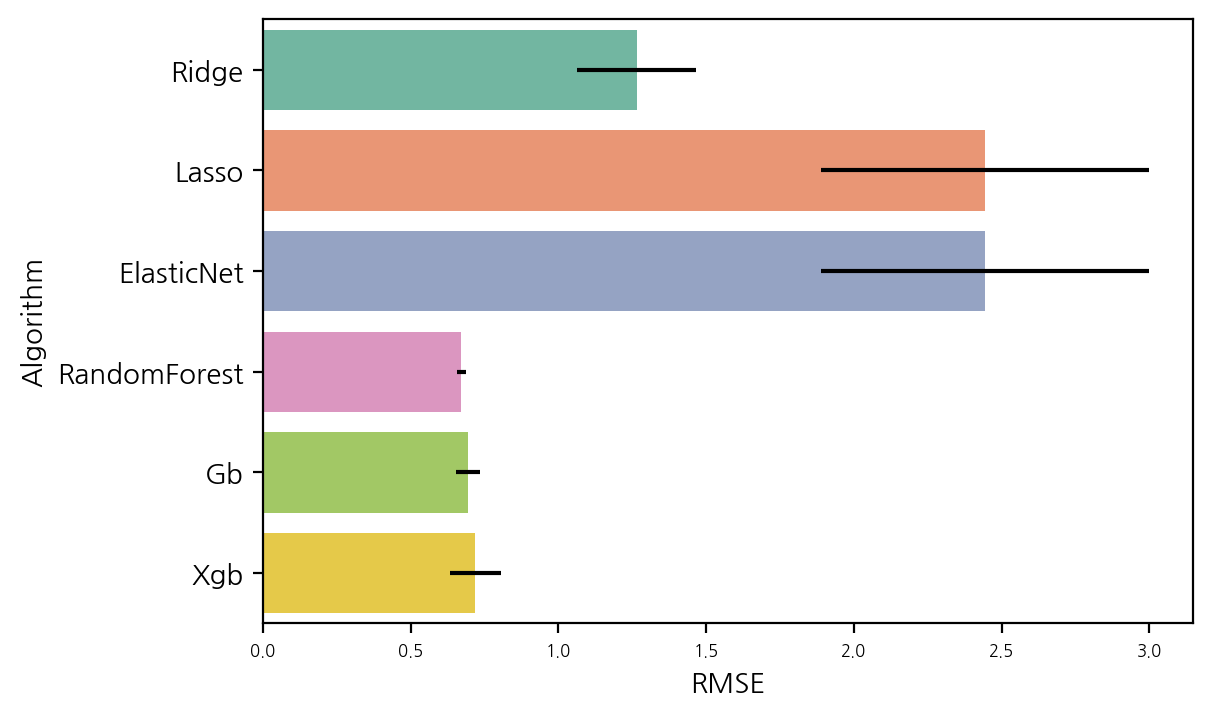

In [105]:
regressifiers = []
regressifiers.append(Ridge(normalize = True, random_state = random_state)) 
regressifiers.append(Lasso(normalize = True, random_state = random_state)) 
regressifiers.append(ElasticNet(normalize = True, random_state = random_state)) 
regressifiers.append(RandomForestRegressor(random_state = random_state)) 
regressifiers.append(GradientBoostingRegressor(random_state = random_state)) 
regressifiers.append(xgb.XGBRegressor(random_state = random_state)) 

cv_results = []
for regressifier in regressifiers :
    cv_results.append(np.sqrt(-cross_val_score(regressifier, data.values, np.ravel(target), scoring = 'neg_mean_squared_error', cv = kfold)))

cv_means = []
cv_std = []
for cv_result in cv_results :
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'Algorithm' : ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'Gb', 'Xgb'],
                        'cv_means' : cv_means,
                        'cv_std' : cv_std})

print(cv_res)
g = sns.barplot('cv_means', 'Algorithm', data = cv_res, palette = 'Set2', orient = "h",**{'xerr':cv_std})
plt.xlabel('RMSE')

In [106]:
ridge = Ridge(normalize = True, random_state = random_state)

ridge_param_grid = {'alpha':  [0.1, 0.2, 0.3, 0.4, 0.5]}
gsRidge = GridSearchCV(estimator = ridge, param_grid = ridge_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsRidge.fit(data, np.ravel(target))
ridge_estimator = gsRidge.best_estimator_
ridge_score = np.sqrt(-gsRidge.best_score_)

print("\nRidge : {0} / {1}\n".format(ridge_estimator, ridge_score))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Ridge : Ridge(alpha=0.1, normalize=True, random_state=14) / 1.0384640750496923



In [107]:
lasso = Lasso(normalize = True, random_state = random_state)

lasso_param_grid = {'alpha':  [0.0001, 0.001, 0.01, 0.1]}
gsLasso = GridSearchCV(estimator = lasso, param_grid = lasso_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsLasso.fit(data, np.ravel(target))
lasso_estimator = gsLasso.best_estimator_
lasso_score = np.sqrt(-gsLasso.best_score_)

print("\nLasso : {0} / {1}\n".format(lasso_estimator, lasso_score))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Lasso : Lasso(alpha=0.001, normalize=True, random_state=14) / 0.9101896912254104



In [108]:
en = ElasticNet(normalize = True, random_state = random_state)

en_param_grid = {'alpha':  [0.0001, 0.001, 0.01, 0.1]}
gsEN = GridSearchCV(estimator = en, param_grid = en_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsEN.fit(data, np.ravel(target))
en_estimator = gsEN.best_estimator_
en_score = np.sqrt(-gsEN.best_score_)

print("\nElasticNet : {0} / {1}\n".format(en_estimator, en_score))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

ElasticNet : ElasticNet(alpha=0.0001, normalize=True, random_state=14) / 1.0016787946075407



In [109]:
rf = RandomForestRegressor(random_state = random_state)
rf_param_grid = {'n_estimators' :[500]}
gsRF = GridSearchCV(estimator = rf, param_grid = rf_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsRF.fit(data, np.ravel(target))
rf_estimator = gsRF.best_estimator_
rf_score = np.sqrt(-gsRF.best_score_)

print("\nRandomForest : {0} / {1}\n".format(rf_estimator, rf_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

RandomForest : RandomForestRegressor(n_estimators=500, random_state=14) / 0.6701307115741314



In [110]:
gb = GradientBoostingRegressor(random_state = random_state)

gb_param_grid = {'n_estimators' : [500]}
gsGB = GridSearchCV(estimator = gb, param_grid = gb_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsGB.fit(data, np.ravel(target))
gb_estimator = gsGB.best_estimator_
gb_score = np.sqrt(-gsGB.best_score_)

print("\nGradientBoosting : {0} / {1}\n".format(gb_estimator, gb_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

GradientBoosting : GradientBoostingRegressor(n_estimators=500, random_state=14) / 0.6562968545746842



In [111]:
xgb = xgb.XGBRegressor(random_state = random_state)

xgb_param_grid = {'max_depth' : [3],
                  'min_child_weight' : [0.001],
                  'colsample_bytree' : [1],
                  'subsample' : [0.8],
                  'gamma' : [0.01],
                  'lambda' : [0.5],
                  'alpha' : [0.01],
                  'learning_rate' : [0.1],
                  'n_estimators' : [500],
                  'eval_metric' : ['rmse']}
gsXGB = GridSearchCV(estimator = xgb, param_grid = xgb_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsXGB.fit(data, np.ravel(target))
xgb_estimator = gsXGB.best_estimator_
xgb_score = np.sqrt(-gsXGB.best_score_)

print("\nXGB : {0} / {1}\n".format(xgb_estimator, xgb_score))

Fitting 5 folds for each of 1 candidates, totalling 5 fits

XGB : XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=0.5, learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=0.001, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=14,
             reg_alpha=0.00999999978, reg_lambda=0.5, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1, ...) / 0.6840498703925689



      Algorithm  h_cv_means  h_cv_std
0         Ridge     1.03675   0.05972
1         Lasso     0.89020   0.18973
2    ElasticNet     0.99995   0.05890
3  RandomForest     0.66989   0.01797
4            Gb     0.65492   0.04252
5           Xgb     0.68257   0.04490


Text(0.5, 0, 'RMSE')

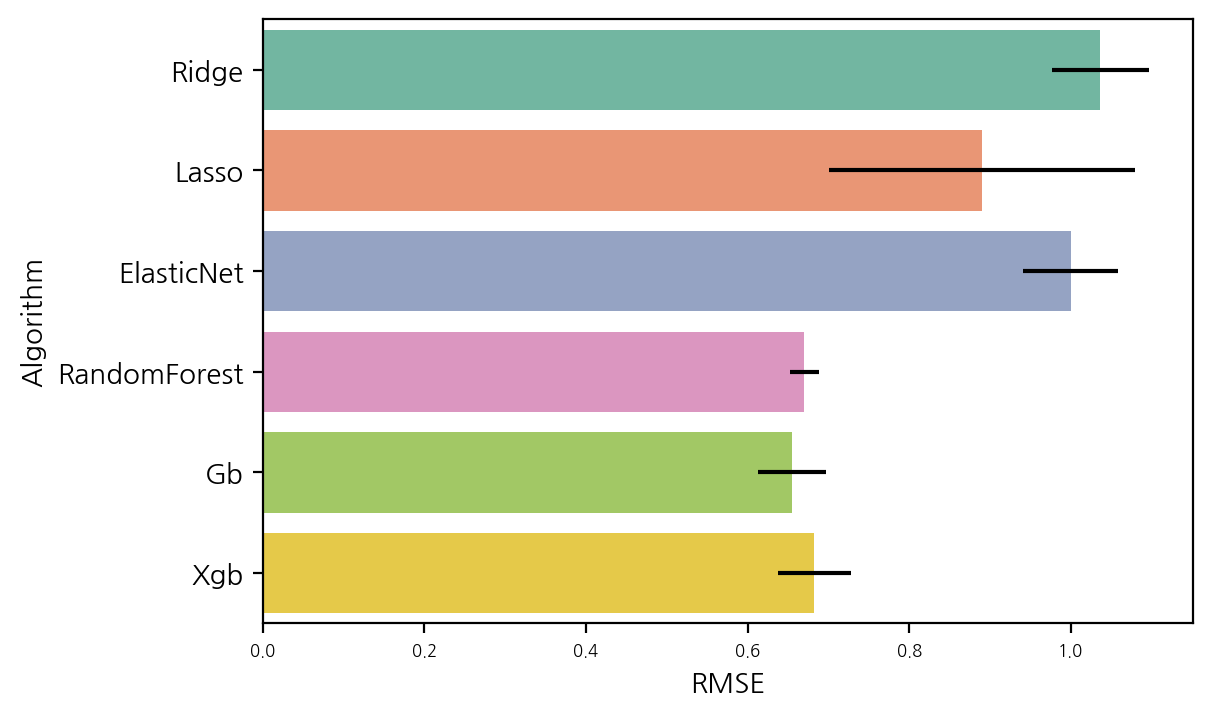

In [112]:
h_regressifiers = []
h_regressifiers.append(gsRidge.best_estimator_) 
h_regressifiers.append(gsLasso.best_estimator_) 
h_regressifiers.append(gsEN.best_estimator_)
h_regressifiers.append(gsRF.best_estimator_) 
h_regressifiers.append(gsGB.best_estimator_) 
h_regressifiers.append(gsXGB.best_estimator_)

h_cv_results = []
for h_regressifier in h_regressifiers :
    h_cv_results.append(np.sqrt(-cross_val_score(h_regressifier, data.values, np.ravel(target), scoring = 'neg_mean_squared_error', cv = kfold)))

h_cv_means = []
h_cv_std = []
for h_cv_result in h_cv_results :
    h_cv_means.append(h_cv_result.mean())
    h_cv_std.append(h_cv_result.std())
    
cv_res = pd.DataFrame({'Algorithm' : ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'Gb', 'Xgb'],
                        'h_cv_means' : h_cv_means,
                        'h_cv_std' : h_cv_std})

print(cv_res)
g = sns.barplot('h_cv_means', 'Algorithm', data = cv_res, palette = 'Set2', orient = "h",**{'xerr':h_cv_std})
plt.xlabel('RMSE')

In [136]:
def clf(x, y):
    # random forest
    rf = rf_estimator
    rf.fit(x, y)
    result_rf = permutation_importance(rf, x,y , n_repeats=10, random_state = 14)
    sorted_idx_rf = result_rf.importances_mean.argsort()
    importances_rf = pd.DataFrame(result_rf.importances_mean[sorted_idx_rf], index=x.columns[sorted_idx_rf], columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending=False)
    
    # gradient boosting
    gb = gb_estimator
    gb.fit(x, y)
    result_gb = permutation_importance(gb, x,y , n_repeats=10, random_state = 14)
    sorted_idx_gb = result_gb.importances_mean.argsort()
    importances_gb = pd.DataFrame(result_gb.importances_mean[sorted_idx_gb], index=x.columns[sorted_idx_gb], columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending=False)
    
    # xg boosting
    xgb = xgb_estimator
    xgb.fit(x, y)
    result_xgb = permutation_importance(xgb, x,y , n_repeats=10, random_state = 14)
    sorted_idx_xgb = result_xgb.importances_mean.argsort()
    importances_xgb = pd.DataFrame(result_xgb.importances_mean[sorted_idx_xgb], index=x.columns[sorted_idx_xgb], columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending=False)
    
    return importances_rf, importances_gb, importances_xgb

In [137]:
importances_rf, importances_gb, importances_xgb = clf(data, target)

importances_rf.to_csv('importances_rf.csv', encoding = 'utf-8-sig')
importances_gb.to_csv('importances_gb.csv', encoding = 'utf-8-sig')
importances_xgb.to_csv('importances_xgb.csv', encoding = 'utf-8-sig')

In [138]:
importances_rf[:10]

,feature_importance
review_cnt,0.75580
instructor_유용한IT학습,0.58681
sale_price,0.06284
price,0.05547
main_category_크리에이티브,0.03244
course_time_min,0.02392
limit_time,0.01617
course_section,0.01099
discount_rate,0.00598
review_score,0.00554


In [139]:
importances_gb[:10]

,feature_importance
review_cnt,0.65460
instructor_유용한IT학습,0.48447
price,0.05701
sale_price,0.03743
main_category_크리에이티브,0.01536
course_time_min,0.01451
instructor_인프런,0.01064
discount_rate,0.00716
instructor_플모,0.00520
course_section,0.00408


In [140]:
importances_xgb[:10]

,feature_importance
review_cnt,0.64504
instructor_유용한IT학습,0.49658
price,0.13950
course_time_min,0.01786
main_category_크리에이티브,0.01358
instructor_인프런,0.01026
discount_rate,0.00947
course_section,0.00628
sale_price,0.00519
instructor_플모,0.00493


In [141]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True, random_state = 14)

In [142]:
votingR = VotingRegressor(estimators = [('rf', rf_estimator), ('gb', gb_estimator), 
('xgb', xgb_estimator)])

votingR.fit(X_train.values, np.ravel(y_train))
votingR_train_pred = votingR.predict(X_train.values) 
votingR_pred = votingR.predict(X_test.values)

In [143]:
class StackingAveragedModels (BaseEstimator, RegressorMixin, TransformerMixin) :
    def __init__(self, base_models, meta_model) :
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit (self, X, y) :
        self.base_models_ = [list() for i in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = 10,  shuffle = True, random_state = random_state)
        
        train_fold_predict = np.zeros((X.shape[0],len(self.base_models)))
        
        for i, model in enumerate (self.base_models) :
            for train_index, valid_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                test_predict = instance.predict(X[valid_index])
                train_fold_predict[valid_index, i] = test_predict
        
        self.meta_model_.fit(train_fold_predict, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [144]:
stacked_model = StackingAveragedModels(base_models = (rf_estimator, gb_estimator, xgb_estimator),
                                                 meta_model = lasso_estimator)

stacked_model.fit(X_train.values, np.ravel(y_train))
stacked_train_pred = stacked_model.predict(X_train.values) 
stacked_pred = stacked_model.predict(X_test.values)

In [145]:
result = pd.DataFrame()
result['value'] = np.ravel(y_test)
result['v_pred'] = votingR_pred
result['s_pred'] = stacked_pred

In [146]:
result['value'] = inv_boxcox1p(result['value'], 0.001)
result['v_pred'] = inv_boxcox1p(result['v_pred'], 0.001)
result['s_pred'] = inv_boxcox1p(result['s_pred'], 0.001)

result = result.round(0)
result = result.astype(int)
result = result.sort_values('value')

In [147]:
print(np.sqrt(mean_squared_error(y_train, votingR_train_pred)))
print(np.sqrt(mean_squared_error(y_train, stacked_train_pred)))
print(np.sqrt(mean_squared_error(y_test, votingR_pred)))
print(np.sqrt(mean_squared_error(y_test, stacked_pred)))

0.29619970089678005
0.3097102236168061
0.5591565429043099
0.5448296826646952


In [148]:
result.to_csv('student_pred.csv')

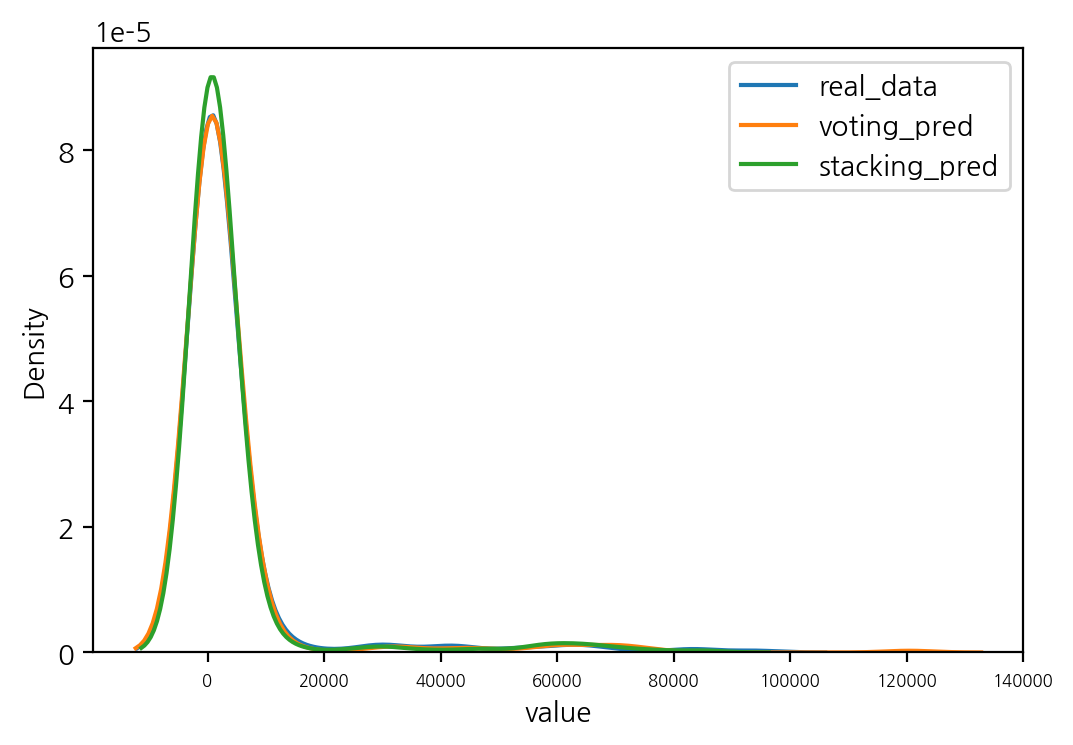

In [149]:
sns.kdeplot(result['value'], shade=False, label = 'real_data')
sns.kdeplot(result['v_pred'], shade=False, label = 'voting_pred')
sns.kdeplot(result['s_pred'], shade=False, label = 'stacking_pred')
plt.legend()

In [150]:
result['v_error'] = (result['value'] - result['v_pred']) / result['value'] *100
result['s_error'] = (result['value'] - result['s_pred']) / result['value'] *100

Text(0, 0.5, 'error rate')

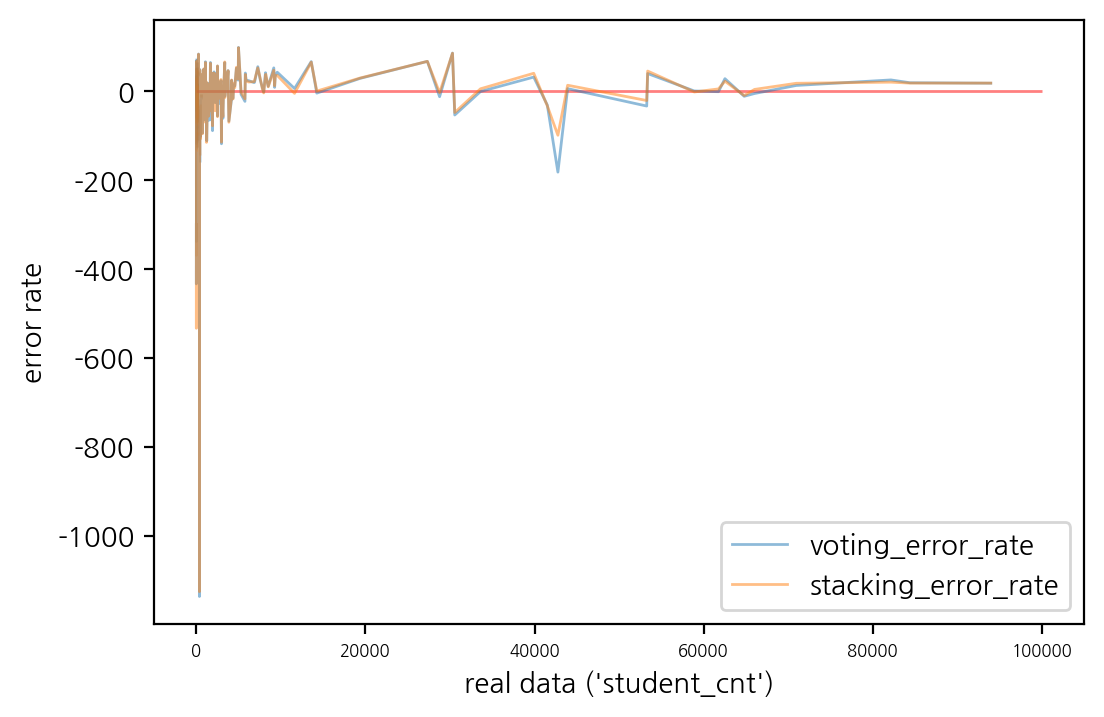

In [151]:
sns.lineplot(x = 'value', y = 'v_error', data = result, linewidth=1, alpha  = 0.5, label = 'voting_error_rate')
sns.lineplot(x = 'value', y = 's_error', data = result, linewidth=1, alpha  = 0.5, label = 'stacking_error_rate')
plt.hlines(0,0,100000, color='r', linewidth=1, alpha  = 0.5)

plt.xlabel("real data ('student_cnt')")
plt.ylabel('error rate')